# Final Project: Overview

# Objective

Given the recent stock market history, I will predict the return for ticker AAPL for the day ahead by the Machine Learning process
**Neural Networks**.



## Get the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import sklearn

import os
import math

%matplotlib inline
#pip install tensorflow_addons

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER()

In [3]:
import numpy as np
import os
DATA_DIR = "./Data"
data_file = "AAPL.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

#target_attr = "stock"

n_samples, n_attrs = data.shape
print("Data shape: ", data.shape)

Data shape:  (4277, 9)


In [4]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = ["Adj Close", "Volume",'Open','High','Low','Close']

ticker_list = [ticker]

appl_data = helper.getData(ticker_list, index_ticker, priceAttr)
appl_data = appl_data.drop(columns=['SPY_Adj_Close', 'SPY_High', 'SPY_Low', 'SPY_Open', 'SPY_Volume','SPY_Close'])
appl_data.head()

,AAPL_Adj_Close,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume
Dt,,,,,,
2000-01-03,3.4785,111.938,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,101.000,95.500,96.5000,115183600.0


In [5]:
# Print the Start time and End time
print("Start time: ", appl_data.index.min())
print("End time: ", appl_data.index.max())

Start time:  2000-01-03
End time:  2016-12-30


## Split the data into training and test set

In [6]:
start_dt = "2000-01-04"
end_dt = "2014-12-31"

def getRange(df, start_dt, end_dt):
    '''
    Return the subset of rows of DataFrame df
    restricted to dates between start_dt and end_dt
    
    Parameters
    ----------
    df: DataFrame
    - The data from which we will take a subset
    
    start_dt: String
    - Start date
    
    end_dt: String
    - End date
    '''
    start_dt1 = pd.to_datetime(start_dt) - pd.tseries.offsets.CustomBusinessDay(n=1)
    start_dt1 = start_dt1.strftime('%Y-%m-%d')
    dataset = df.loc[start_dt1:end_dt]
    return dataset

train_data_price = getRange(appl_data, start_dt, end_dt)
train_data_price.head()

,AAPL_Adj_Close,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume
Dt,,,,,,
2000-01-03,3.4785,111.938,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,101.000,95.500,96.5000,115183600.0


In [7]:
test_start_dt = '2015-01-02'
test_end_dt = '2016-12-30'

test_data_price = getRange(appl_data, test_start_dt, test_end_dt)
test_data_price.head()

,AAPL_Adj_Close,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume
Dt,,,,,,
2015-01-02,100.4543,109.33,111.4400,107.350,111.39,53204600.0
2015-01-05,97.6243,106.25,108.6500,105.410,108.29,64285500.0
2015-01-06,97.6335,106.26,107.4300,104.630,106.54,65797100.0
2015-01-07,99.0026,107.75,108.2000,106.695,107.20,40105900.0
2015-01-08,102.8065,111.89,112.1595,108.700,109.23,59364500.0


## Exploratory Data Analysis

We begin with an in-depth exploratory analysis to understand the characteristics of dataset:


Trend analysis: Look for patterns, trends, and seasonality in the AAPL stock prices.
Volatility analysis: Assess the volatility in the stock prices, which can be crucial for predicting returns.
Missing values: Identify if there are gaps or missing data points and decide how to handle them.
Distribution of returns: Analyze the statistical properties of stock returns, such as mean, variance, skewness, and kurtosis.

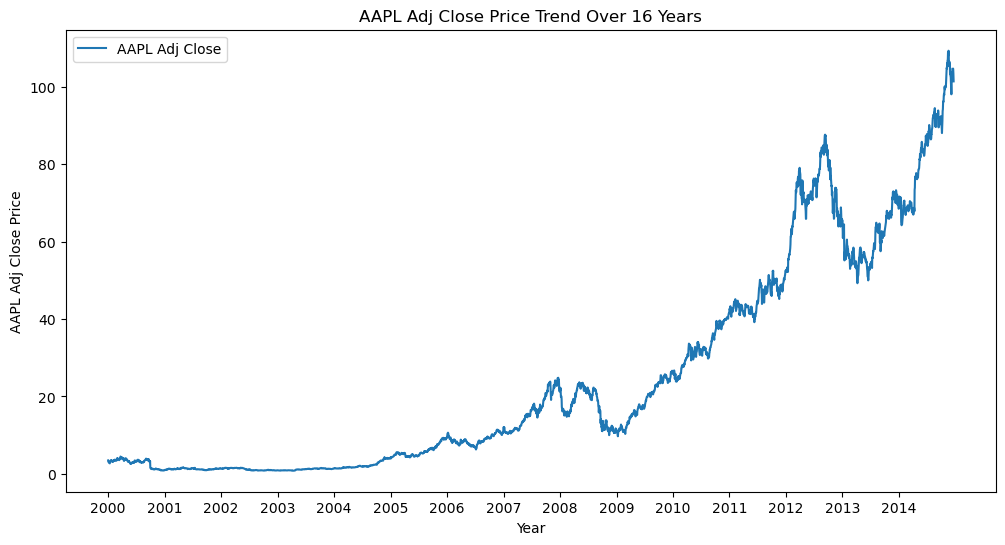

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_price['AAPL_Adj_Close'], label='AAPL Adj Close')

# Setting x ticks to be yearly
plt.xticks(train_data_price.index[::252], [str(year)[:4] for year in train_data_price.index[::252]])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('AAPL Adj Close Price')
plt.title('AAPL Adj Close Price Trend Over 16 Years')

# Adding legend
plt.legend()

# Show the plot
plt.show();

As we can see from the graph above, the APPL close price has an increasing trend in long-term, which is not stationary. So we need to compute returns for analysis.  

I used adjust stock price to calculate return since it would more accurately reflect stock's performance. Some events such as stock splits, dividends, and rights offerings can definitely impact stock price, and adjust stock price is the price take these influences into considerations.
We also computed lagged returns for 10 days and moving average across 5, 10, 20, 50, 100, 200 days. 


Moreover, RSI is calculated and hopefully it can offer some insights when predicting the returns because it measures the speed and magnitude of a security's recent price changes.

### Feature Engineering

In [9]:
def transform_data(data, lag_days=10, moving_averages=[5, 10, 20, 50, 100, 200]):
    data = data.copy()
    # Calculate daily returns
    data['AAPL_Return'] = data['AAPL_Adj_Close'].pct_change()
    data['AAPL_HL'] = data['AAPL_High'] - data['AAPL_Low']
    data['AAPL_CO'] = data['AAPL_Close'] - data['AAPL_Open']
    data['AAPL_SD'] = data['AAPL_Adj_Close'].rolling(window=7).std()

    # Create lagged returns as features
    for i in range(1, lag_days + 1):
        data[f'Return_Lag_{i}'] = data['AAPL_Return'].shift(i)

    # Add additional technical indicators as features (e.g., moving averages, RSI)
    for i in moving_averages:
        data[f'MA_{i}'] = data['AAPL_Adj_Close'].rolling(window=i).mean()

    data['RSI'] = 100 - (100 / (1 + data['AAPL_Adj_Close'].pct_change().rolling(window=14).mean()))
    
    columns_to_drop = ['AAPL_Close', 'AAPL_High', 'AAPL_Low', 'AAPL_Open','AAPL_Adj_Close']
    data = data.drop(columns=columns_to_drop)
    
    # Drop NaN values created by lagging and rolling calculations
    data = data.dropna()
    
    return data


train_data = transform_data(train_data_price)
train_data.head()


,AAPL_Volume,AAPL_Return,AAPL_HL,AAPL_CO,AAPL_SD,Return_Lag_1,Return_Lag_2,Return_Lag_3,Return_Lag_4,Return_Lag_5,...,Return_Lag_8,Return_Lag_9,Return_Lag_10,MA_5,MA_10,MA_20,MA_50,MA_100,MA_200,RSI
Dt,,,,,,,,,,,,,,,,,,,,,
2000-10-16,205044000.0,-0.025525,1.8750,-0.813,0.062753,0.103138,0.019103,-0.059889,-0.040243,-0.019724,...,0.058845,-0.079889,-0.058298,1.29350,1.34245,2.185305,2.913088,3.022733,3.293073,-4.766664
2000-10-17,150430000.0,-0.063913,2.2491,-1.563,0.059245,-0.025525,0.103138,0.019103,-0.059889,-0.040243,...,-0.066131,0.058845,-0.079889,1.28418,1.32886,2.061590,2.878518,3.008123,3.281935,-4.887011
2000-10-18,208566400.0,0.000000,2.3148,0.687,0.055494,-0.063913,-0.025525,0.103138,0.019103,-0.059889,...,0.005688,-0.066131,0.058845,1.29040,1.30711,1.934425,2.845424,2.993790,3.272263,-5.624616
2000-10-19,376681200.0,-0.059002,1.5000,-0.218,0.067114,0.000000,-0.063913,-0.025525,0.103138,0.019103,...,-0.019724,0.005688,-0.066131,1.27720,1.28769,1.817120,2.809922,2.978350,3.261989,-2.084266
2000-10-20,197815800.0,0.029652,1.4370,0.437,0.068032,-0.059002,0.000000,-0.063913,-0.025525,0.103138,...,-0.040243,-0.019724,0.005688,1.24534,1.27098,1.715540,2.775040,2.964366,3.253288,-1.433766


In [10]:
tickerAttr = ticker + "_Return"
tickerAttr

'AAPL_Return'

In [11]:
X_train, y_train =  train_data.drop(columns=[tickerAttr]), train_data[[ tickerAttr ]]
print("trian data length", train_data.shape)
print("X trian length", X_train.shape)
print("y trian length", y_train.shape)

trian data length (3574, 22)
X trian length (3574, 21)
y trian length (3574, 1)


<Figure size 1500x900 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'AAPL Return')

Text(0.5, 1.0, 'AAPL Return Over Time')

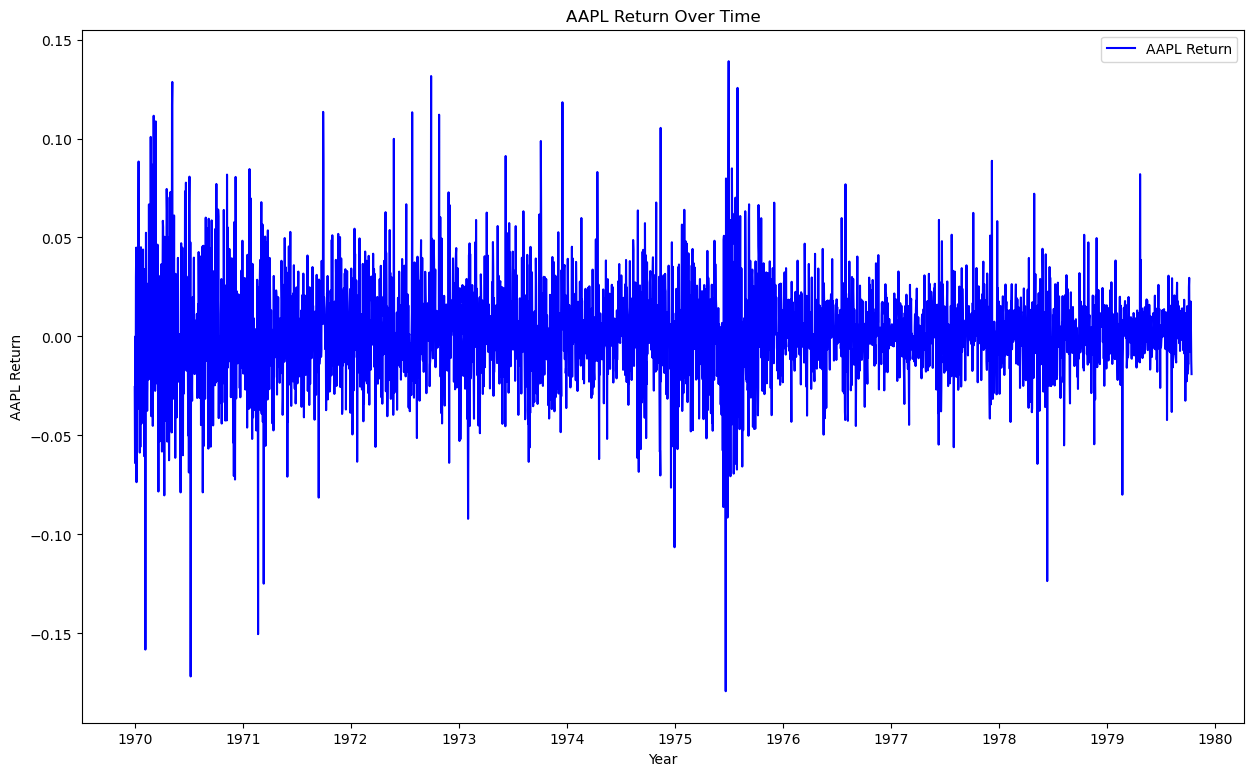

In [12]:
plt.figure(figsize=(15, 9))
plt.plot(train_data['AAPL_Return'], label='AAPL Return', color='blue')
plt.xlabel('Year')
plt.ylabel('AAPL Return')
plt.title('AAPL Return Over Time')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
adfuller(train_data['AAPL_Return'])

(-29.65042155788174,
 0.0,
 3,
 3570,
 {'1%': -3.432183055516335,
  '5%': -2.862349940934467,
  '10%': -2.567201144771634},
 -16084.720571722592)

From the graph and result of ADF test, we can say AAPL return is stationary.  
We will include 'Volume' and other computed features such as lagged returns, moving average and RSI in our X.

### Transform the test data set

In [14]:
test_data = transform_data(test_data_price)

X_test, y_test =  test_data.drop(columns=[tickerAttr]), test_data[[ tickerAttr ]]
print("test data length", test_data.shape)
print("X test length", X_test.shape)
print("y test length", y_test.shape)

test data length (305, 22)
X test length (305, 21)
y test length (305, 1)


### Split the training set again to get validation dataset.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42,shuffle=False)

## Model Selection- DNN

In [16]:
# Build a simple neural network model
model0 = Sequential([Dense(16, activation='relu', input_dim=X_train.shape[1]),
                     Dense(1, activation='linear')
    
])

In [17]:
max_epochs = 15
metrics = ['mean_absolute_error']
loss = 'mean_squared_error'
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data using the same scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Compile the model
model0.compile(optimizer='adam',
               loss=loss,
               metrics=metrics)

# Train the model
history0 = model0.fit(X_train_scaled, y_train, 
                      epochs=max_epochs, 
                      batch_size=64, 
                      validation_data=(X_valid_scaled, y_valid), 
                      shuffle=False)
model_name0 = 'Simple'

Epoch 1/15
 1/45 [..............................] - ETA: 6s - loss: 1.3525 - mean_absolute_error: 0.8998

2024-05-02 12:59:04.621632: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 0s 2ms/step - loss: 0.9535 - mean_absolute_error: 0.7176 - val_loss: 4.9542 - val_mean_absolute_error: 2.0821
Epoch 2/15
45/45 [==============================] - 0s 752us/step - loss: 0.3074 - mean_absolute_error: 0.4000 - val_loss: 0.6836 - val_mean_absolute_error: 0.6665
Epoch 3/15
45/45 [==============================] - 0s 733us/step - loss: 0.1874 - mean_absolute_error: 0.3216 - val_loss: 0.2222 - val_mean_absolute_error: 0.3506
Epoch 4/15
45/45 [==============================] - 0s 714us/step - loss: 0.1381 - mean_absolute_error: 0.2789 - val_loss: 0.1692 - val_mean_absolute_error: 0.3099
Epoch 5/15
45/45 [==============================] - 0s 714us/step - loss: 0.1115 - mean_absolute_error: 0.2521 - val_loss: 0.1477 - val_mean_absolute_error: 0.2929
Epoch 6/15
45/45 [==============================] - 0s 715us/step - loss: 0.0941 - mean_absolute_error: 0.2323 - val_loss: 0.1266 - val_mean_absolute_error: 0.2738
Epoch 7/15
45/45 [===========

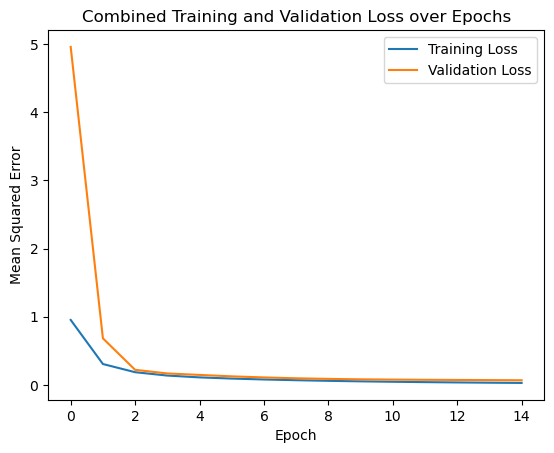

In [18]:
def plot_combined_loss(history):
    """
    Plot combined training loss and validation loss over epochs on the same graph.

    Parameters:
    - history: The history object returned by the model.fit() function.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Combined Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()


plot_combined_loss(history0)

In [19]:
num_parameters0 = model0.count_params()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  369


In [20]:
score0 = model0.evaluate(X_test_scaled, y_test)
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name0, l=score0[0], a=score0[1]))

10/10 [==============================] - 0s 484us/step - loss: 0.2742 - mean_absolute_error: 0.5025
Simple: Test Mean Squared Error: 0.274233 / Mean Absolute Error: 0.502519


### Evaluation- plot actual and prediction 

10/10 [==============================] - 0s 373us/step


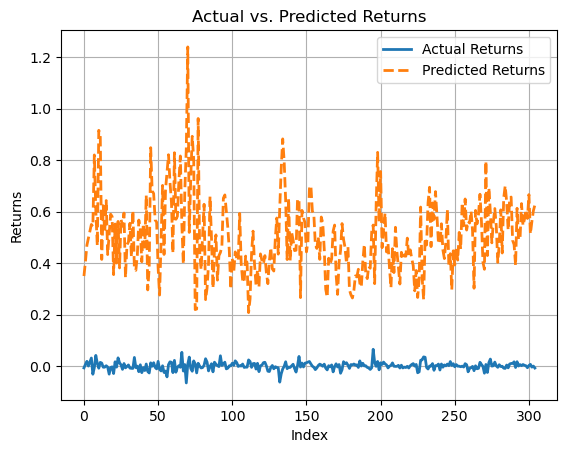

In [21]:
def plot_actual_vs_predicted(model, X_test_scaled, y_test):
    
    # Make predictions using the model
    predictions = model.predict(X_test_scaled)
    
    # Create a DataFrame with actual and predicted returns
    result_df = pd.DataFrame({'Actual_Return': y_test.values.ravel(), 'Predicted_Return': predictions.flatten()})
    
    # Plotting the actual returns
    plt.plot(result_df['Actual_Return'], label='Actual Returns', linewidth=2)

    # Plotting the predicted returns
    plt.plot(result_df['Predicted_Return'], label='Predicted Returns', linestyle='dashed', linewidth=2)

    # Adding labels and title
    plt.xlabel('Index')
    plt.ylabel('Returns')
    plt.title('Actual vs. Predicted Returns')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

plot_actual_vs_predicted(model0, X_test_scaled, y_test)

## More layers-1

In [22]:
from tensorflow.keras.layers import Dropout
model1_2 = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model1_2.compile(optimizer='adam',
               loss=loss,
               metrics=metrics)

history1_2 = model1_2.fit(X_train_scaled, y_train, 
                      epochs=max_epochs, 
                      batch_size=64, 
                      validation_data=(X_valid_scaled, y_valid), 
                      shuffle=False
                         )
model_name1_2 = '3 Layers + Head'


Epoch 1/15
45/45 [==============================] - 0s 2ms/step - loss: 0.6857 - mean_absolute_error: 0.5918 - val_loss: 2.1578 - val_mean_absolute_error: 1.3586
Epoch 2/15
45/45 [==============================] - 0s 783us/step - loss: 0.2443 - mean_absolute_error: 0.3390 - val_loss: 0.5650 - val_mean_absolute_error: 0.6464
Epoch 3/15
45/45 [==============================] - 0s 754us/step - loss: 0.1286 - mean_absolute_error: 0.2359 - val_loss: 0.2149 - val_mean_absolute_error: 0.3687
Epoch 4/15
45/45 [==============================] - 0s 756us/step - loss: 0.0799 - mean_absolute_error: 0.1852 - val_loss: 0.1058 - val_mean_absolute_error: 0.2441
Epoch 5/15
45/45 [==============================] - 0s 755us/step - loss: 0.0581 - mean_absolute_error: 0.1521 - val_loss: 0.0603 - val_mean_absolute_error: 0.1806
Epoch 6/15
45/45 [==============================] - 0s 756us/step - loss: 0.0423 - mean_absolute_error: 0.1338 - val_loss: 0.0410 - val_mean_absolute_error: 0.1507
Epoch 7/15
45/45 [

In [23]:
num_parameters1 = model1_2.count_params()

print("Parameters number in model0: ", num_parameters1)

Parameters number in model0:  497


In [24]:
score1 = model1_2.evaluate(X_test_scaled, y_test)                                                                            

print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name1_2, l=score1[0], a=score1[1]))

10/10 [==============================] - 0s 416us/step - loss: 0.0134 - mean_absolute_error: 0.1032
3 Layers + Head: Test Mean Squared Error: 0.013440 / Mean Absolute Error: 0.103193


10/10 [==============================] - 0s 349us/step


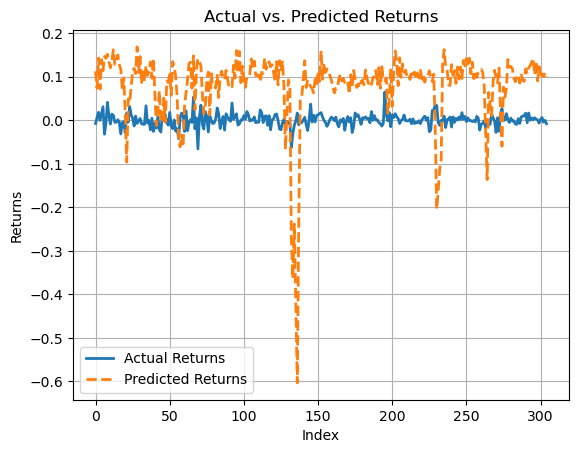

In [25]:
plot_actual_vs_predicted(model1_2, X_test_scaled, y_test)

## More layers-2

In [26]:
from tensorflow.keras.layers import Dropout

model1 = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model1.compile(optimizer='adam',
               loss=loss,
               metrics=metrics)

history1 = model1.fit(X_train_scaled, y_train, 
                      epochs=max_epochs, 
                      batch_size=64, 
                      validation_data=(X_valid_scaled, y_valid), 
                      shuffle=False
                         )
model_name1 = '5 Layers + Head'


Epoch 1/15
45/45 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0536 - val_loss: 4.5259e-04 - val_mean_absolute_error: 0.0166
Epoch 2/15
45/45 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0257 - val_loss: 3.6085e-04 - val_mean_absolute_error: 0.0133
Epoch 3/15
45/45 [==============================] - 0s 1ms/step - loss: 9.7441e-04 - mean_absolute_error: 0.0226 - val_loss: 2.9184e-04 - val_mean_absolute_error: 0.0120
Epoch 4/15
45/45 [==============================] - 0s 1ms/step - loss: 8.6564e-04 - mean_absolute_error: 0.0210 - val_loss: 2.8587e-04 - val_mean_absolute_error: 0.0119
Epoch 5/15
45/45 [==============================] - 0s 1ms/step - loss: 7.9686e-04 - mean_absolute_error: 0.0204 - val_loss: 2.8620e-04 - val_mean_absolute_error: 0.0120
Epoch 6/15
45/45 [==============================] - 0s 1ms/step - loss: 8.0276e-04 - mean_absolute_error: 0.0204 - val_loss: 2.8673e-04 - val_mean_absolute_er

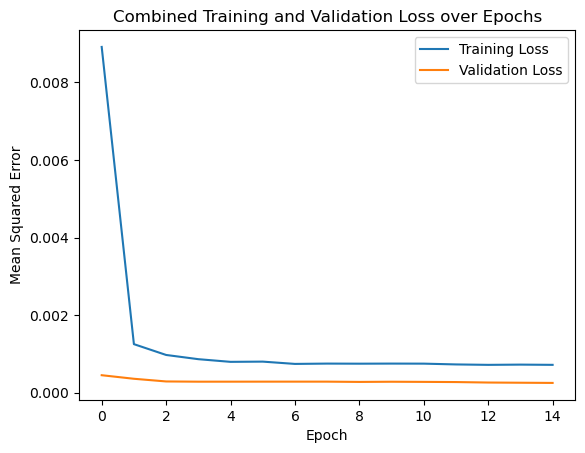

In [27]:
plot_combined_loss(history1)

In [28]:
num_parameters1 = model1.count_params()

print("Parameters number in model0: ", num_parameters1)

Parameters number in model0:  19073


In [29]:
score1 = model1.evaluate(X_test_scaled, y_test)                                                                            

print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name1, l=score1[0], a=score1[1]))

10/10 [==============================] - 0s 815us/step - loss: 2.2719e-04 - mean_absolute_error: 0.0107
5 Layers + Head: Test Mean Squared Error: 0.000227 / Mean Absolute Error: 0.010744


10/10 [==============================] - 0s 397us/step


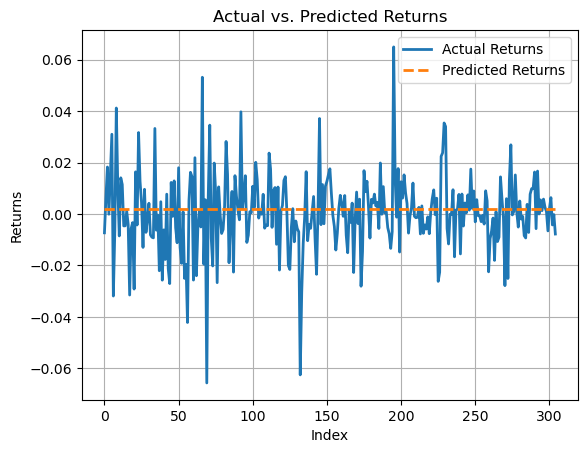

In [30]:
plot_actual_vs_predicted(model1, X_test_scaled, y_test)

 Among three models tried on only APPL features, the model with 5 layers has the smallest loss. 

## Model2 - Adding more features
The simple model only uses features from AAPL, now I will add some new features into the model to see if it performs better.  
First, I will compute a correlation matrix of all tickers close prices and volumes, and tickers with high correlation with AAPL prices will be included in my new model.

### Data preparation

In [31]:
ticker_list = ['AAPL','ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
all_data = helper.getData(ticker_list, index_ticker, priceAttr)

In [32]:
correlation_matrix = all_data.corr()
high_corr_pairs = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1.0)
high_corr_features = correlation_matrix.columns[high_corr_pairs.any()]


In [33]:
ticker = [col.split('_')[0] for col in high_corr_features]
unique_tickers = set(ticker)
print(unique_tickers)
len(unique_tickers)

{'XLI', 'AAPL', 'NVDA', 'XLU', 'XLB', 'ADBE', 'XLRE', 'XLP', 'XLK', 'FB', 'XLY', 'XLV', 'MA', 'V', 'MSFT', 'CSCO', 'INTC', 'XLE', 'XLF', 'SPY', 'GOOG', 'IBM', 'ACN', 'CRM'}


24

In [34]:
data = all_data[high_corr_features]
data.dropna()

,AAPL_Adj_Close,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,ACN_Adj_Close,ACN_Close,ACN_High,ACN_Low,ACN_Open,...,XLY_High,XLY_Low,XLY_Open,XLY_Volume,SPY_Adj_Close,SPY_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume
Dt,,,,,,,,,,,,,,,,,,,,,
2015-10-08,101.8886,109.50,110.1900,108.21,110.1900,96.8320,105.01,105.2700,102.1900,102.5100,...,77.7400,76.330,76.36,6341600.0,185.9063,201.21,201.55,198.59,198.95,153055200.0
2015-10-09,104.3265,112.12,112.2726,109.49,110.0000,96.6199,104.78,106.4810,104.6700,105.1100,...,77.7903,77.280,77.65,8352700.0,186.0172,201.33,201.90,200.58,201.38,107069200.0
2015-10-12,103.8426,111.60,112.7500,111.44,112.7300,96.8689,105.05,105.2200,104.6100,104.6861,...,78.3000,77.760,77.77,5489000.0,186.1927,201.52,201.76,200.91,201.42,56395600.0
2015-10-13,104.0194,111.79,112.4500,110.68,110.8200,95.4211,103.48,104.6200,102.7278,103.0000,...,78.5000,77.570,77.83,7581500.0,185.0193,200.25,202.16,200.05,200.65,88038700.0
2015-10-14,102.5493,110.21,111.5200,109.56,111.2900,95.4678,102.43,102.9500,101.2000,102.2200,...,77.9350,76.710,77.67,7015900.0,184.1324,199.29,200.87,198.94,200.18,99106200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.52,116.5255,115.59,115.5900,111.7080,117.48,118.2100,117.1100,117.4000,...,82.7650,82.351,82.61,2837000.0,214.2890,225.71,225.72,225.21,225.43,36697800.0
2016-12-27,112.0142,117.26,117.8000,116.49,116.5200,111.7746,117.55,118.4817,117.2100,117.3600,...,83.1000,82.510,82.51,6101100.0,214.8206,226.27,226.73,226.00,226.02,42672500.0
2016-12-28,111.5366,116.76,118.0170,116.20,117.5200,110.8808,116.61,118.0000,116.0900,118.0000,...,83.0300,82.180,82.95,3857700.0,213.0452,224.40,226.59,224.27,226.57,64095000.0


From the correlation matrix, we know all 24 tickers provided are highly correlated with AAPL prices, but after dropping all NA values, we are only left with 311 examples. In addition, correlation does not imply causation. I will first filter the tickers whose correlation coefficient is > 0.9, then choose some tickers with early starting points and relevant fields with APPLE.

In [35]:
high_corr_pairs = (correlation_matrix.abs() > 0.9) & (correlation_matrix.abs() < 1.0)
high_corr_features = correlation_matrix.columns[high_corr_pairs.any()]
print(high_corr_features)

Index(['AAPL_Adj_Close', 'AAPL_Close', 'AAPL_High', 'AAPL_Low', 'AAPL_Open',
       'ACN_Adj_Close', 'ACN_Close', 'ACN_High', 'ACN_Low', 'ACN_Open',
       ...
       'XLY_Adj_Close', 'XLY_Close', 'XLY_High', 'XLY_Low', 'XLY_Open',
       'SPY_Adj_Close', 'SPY_Close', 'SPY_High', 'SPY_Low', 'SPY_Open'],
      dtype='object', length=117)


In [36]:
ticker = [col.split('_')[0] for col in high_corr_features]
unique_tickers = set(ticker)
print(unique_tickers)
len(unique_tickers)

{'XLI', 'AAPL', 'NVDA', 'XLU', 'XLB', 'ADBE', 'XLRE', 'XLP', 'XLK', 'FB', 'XLY', 'XLV', 'MA', 'V', 'MSFT', 'CSCO', 'INTC', 'XLE', 'XLF', 'SPY', 'GOOG', 'IBM', 'ACN', 'CRM'}


24

In [37]:
start_dates = data.apply(lambda col: col.first_valid_index())

# Create a set to keep track of tickers
processed_tickers = set()

# Display or print start dates for each column
for stock, start_date in start_dates.items():
    # Check if the ticker has been processed
    if stock.split('_')[0] not in processed_tickers:
        # Print the start date
        print(f'{stock.split("_")[0]}: {start_date}')
        
        # Add the ticker to the set of processed tickers
        processed_tickers.add(stock.split('_')[0])

AAPL: 2000-01-03
ACN: 2001-07-19
ADBE: 2000-01-03
CRM: 2004-06-23
CSCO: 2000-01-03
FB: 2012-05-18
GOOG: 2004-08-19
IBM: 2000-01-03
INTC: 2000-01-03
MA: 2006-05-25
MSFT: 2000-01-03
NVDA: 2000-01-03
V: 2008-03-19
XLB: 2000-01-03
XLE: 2000-01-03
XLF: 2000-01-03
XLI: 2000-01-03
XLK: 2000-01-03
XLP: 2000-01-03
XLRE: 2015-10-08
XLU: 2000-01-03
XLV: 2000-01-03
XLY: 2000-01-03
SPY: 2000-01-03


To choose which tickers we need to compare, we should take a look on what these stocks are related to AAPL:

Among the given stocks, those most related to AAPL are likely other companies in the technology sector, as they may be influenced by similar market factors and industry dynamics. Among these stocks, MSFT (Microsoft), GOOG (Google), and FB (Facebook) are likely the most relevant, as they are leading companies in the technology industry with products and services similar to Apple's. But FB's data points started in 2012, which will truncate the whole dataset.    

Additionally, CRM is a cloud-based software company that specializes in customer relationship management (CRM) solutions. Apple also has its own cloud service, and they became a partner in 2018.  
NVDA and INTC are semiconductor companies, and Appleis related to the semiconductor industry, such as manufacturing of components and processor development.  
ACN close price is highly correlated with Appleclose price, and in 2017 they collaborated on enterprise Apps.  
V and MA belong to financial services, with ApplePay increasing, they might be correlated
XLK is Technology Select Sector SPDR Fund.  
XLV is Health Care Select Sector SPDR Fund. Apple has been using iWatch and other softwares to help people monitor health.  


In [38]:
tickers = ['ADBE', 'MSFT', 'GOOG', 'CRM', 'AAPL', 'NVDA', 'INTC', 'ACN', 'V', 'MA', 'XLK', 'XLV']
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = ["Adj Close", "Volume",'High','Low','Open']

data = helper.getData(tickers, index_ticker, priceAttr)
data.head()

,ADBE_Adj_Close,ADBE_High,ADBE_Low,ADBE_Open,ADBE_Volume,MSFT_Adj_Close,MSFT_High,MSFT_Low,MSFT_Open,MSFT_Volume,...,XLV_Adj_Close,XLV_High,XLV_Low,XLV_Open,XLV_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,16.2747,67.500,64.250,67.2500,7384400.0,37.6233,118.625,112.000,117.375,53228400.0,...,22.8577,31.000,30.063,31.000,246700.0,100.4705,148.2472,143.875,148.250,8164300.0
2000-01-04,14.9094,65.813,59.938,63.0000,7813200.0,36.3524,117.125,112.250,113.563,54119000.0,...,22.3390,30.203,29.531,30.188,35300.0,96.5415,144.0630,139.641,143.531,8089800.0
2000-01-05,15.2042,62.750,58.250,58.2500,14927200.0,36.7357,116.375,109.375,111.125,64059600.0,...,22.1386,29.781,29.219,29.781,137600.0,96.7142,141.5284,137.250,139.938,12177900.0
2000-01-06,15.3283,62.625,60.625,61.4393,10221200.0,35.5051,113.875,108.375,112.188,54976600.0,...,22.2093,29.563,29.156,29.313,50000.0,95.1599,141.5000,137.750,139.625,6227200.0
2000-01-07,16.0730,64.750,60.875,61.5630,8253200.0,35.9691,112.250,107.313,108.625,62013600.0,...,22.4804,29.797,29.359,29.469,22100.0,100.6864,145.7500,140.063,140.313,8066500.0


### Split the training and test set

In [39]:
train_data_price = getRange(data, start_dt, end_dt)
train_data_price = train_data_price.dropna()
train_data_price.head()

,ADBE_Adj_Close,ADBE_High,ADBE_Low,ADBE_Open,ADBE_Volume,MSFT_Adj_Close,MSFT_High,MSFT_Low,MSFT_Open,MSFT_Volume,...,XLV_Adj_Close,XLV_High,XLV_Low,XLV_Open,XLV_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume
Dt,,,,,,,,,,,,,,,,,,,,,
2008-03-19,34.75,36.13,33.76,33.7800,25122000.0,21.7696,29.590,28.62,29.3822,61442100.0,...,25.4058,31.91,30.51,31.41,7359700.0,102.3344,134.650,130.0400,134.1405,345971600.0
2008-03-20,34.45,35.50,34.25,34.8196,12402200.0,22.1956,29.221,28.59,28.7400,60170200.0,...,25.4377,31.51,30.95,31.51,2022000.0,104.2299,132.910,129.2502,130.0500,245320700.0
2008-03-24,36.10,36.49,34.51,34.6440,10783000.0,22.1879,29.400,29.06,29.3300,48294700.0,...,25.7731,31.70,31.23,31.43,2458700.0,106.3132,135.810,133.2400,133.3100,208977300.0
2008-03-25,36.54,36.65,35.81,36.5800,8940000.0,22.1651,29.370,28.94,29.3300,49149000.0,...,25.8222,31.70,31.38,31.49,3434700.0,106.4158,135.550,133.7700,134.8602,192947200.0
2008-03-26,37.20,37.34,35.96,36.5100,11395700.0,21.7240,29.070,28.38,29.0300,45868100.0,...,25.5686,31.43,31.25,31.41,2507200.0,105.1137,135.088,133.1100,134.4521,196934300.0


In [40]:
test_data_price = getRange(data, test_start_dt, test_end_dt)
test_data_price.head()

,ADBE_Adj_Close,ADBE_High,ADBE_Low,ADBE_Open,ADBE_Volume,MSFT_Adj_Close,MSFT_High,MSFT_Low,MSFT_Open,MSFT_Volume,...,XLV_Adj_Close,XLV_High,XLV_Low,XLV_Open,XLV_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume
Dt,,,,,,,,,,,,,,,,,,,,,
2015-01-02,72.34,73.203,71.8941,72.70,2349200.0,42.1220,47.420,46.5400,46.66,27913900.0,...,63.8044,69.350,68.35,68.71,7516800.0,187.0746,206.88,204.180,206.3800,121465900.0
2015-01-05,71.98,72.430,71.5700,72.21,2403300.0,41.7347,46.730,46.2500,46.37,39673900.0,...,63.4790,68.875,68.15,68.32,10784800.0,183.6961,204.37,201.350,204.1652,169632600.0
2015-01-06,70.53,72.100,69.8800,71.95,2895400.0,41.1221,46.749,45.5413,46.38,36447900.0,...,63.2652,69.090,67.63,68.51,13344500.0,181.9659,202.72,198.855,202.0900,209151400.0
2015-01-07,71.11,71.290,70.4200,70.77,2378300.0,41.6446,46.460,45.4900,45.98,29114100.0,...,64.7527,69.670,68.36,68.51,14146400.0,184.2334,202.72,200.880,201.4200,125346700.0
2015-01-08,72.92,73.060,71.3100,71.40,2624200.0,42.8697,47.750,46.7200,46.75,29645200.0,...,65.8590,70.920,70.22,70.34,22138400.0,187.5026,206.16,203.990,204.0100,147217800.0


### Transformation
First, we calculate the returns for all stocks in the dataset. Then, we generate additional features, such as the moving averages over 5, 20, and 50 days, lag returns for 1 and 2 days, and the Relative Strength Index (RSI). 

The input features consist of volumes, moving averages, returns, lag returns, and RSI for selected stocks, as well as the price difference between the high and low of AAPL.

In [41]:
def transform(data, tickers):
    data = data.copy()
    for ticker in tickers:
        data[f'{ticker}_Return'] = data[f'{ticker}_Adj_Close'].pct_change()
        data['AAPL_HL'] = data['AAPL_High'] - data['AAPL_Low']
        data[f'{ticker}_5_Day_MA'] = data[f'{ticker}_Adj_Close'].rolling(window=5).mean()
        data[f'{ticker}_20_Day_MA'] = data[f'{ticker}_Adj_Close'].rolling(window=20).mean()
        data[f'{ticker}_50_Day_MA'] = data[f'{ticker}_Adj_Close'].rolling(window=50).mean()
        data[f'{ticker}_RSI'] = 100 - (100 / (1 + data[f'{ticker}_Adj_Close'].pct_change().rolling(window=14).mean()))

        for lag in range(1, 3):
            data[f'{ticker}_Return_Lag_{lag}'] = data[f'{ticker}_Adj_Close'].pct_change().shift(lag)
    
    # Drop columns containing 'high', 'low', 'open', 'close'
    data = data.drop(data.filter(like='High').columns, axis=1) #  selects columns whose names contain the substring "High".
    data = data.drop(data.filter(like='Low').columns, axis=1)
    data = data.drop(data.filter(like='Open').columns, axis=1)
    data = data.drop(data.filter(like='Close').columns, axis=1)
    
    data = data.dropna()
    return data

# Example usage with your train_data_price
train_data = transform(train_data_price, tickers)
train_data.head()
print(train_data.columns)

,ADBE_Volume,MSFT_Volume,GOOG_Volume,CRM_Volume,AAPL_Volume,NVDA_Volume,INTC_Volume,ACN_Volume,V_Volume,MA_Volume,...,XLK_RSI,XLK_Return_Lag_1,XLK_Return_Lag_2,XLV_Return,XLV_5_Day_MA,XLV_20_Day_MA,XLV_50_Day_MA,XLV_RSI,XLV_Return_Lag_1,XLV_Return_Lag_2
Dt,,,,,,,,,,,,,,,,,,,,,
2008-05-29,6736600.0,47699200.0,9726200.0,10406000.0,161796600.0,17336500.0,54937400.0,4148800.0,100613200.0,130014000.0,...,0.184725,0.005627,0.016337,0.021623,25.90078,25.942095,25.841226,0.145633,-0.000955,0.004148
2008-05-30,5842500.0,63399200.0,6474500.0,18095200.0,152546100.0,20756100.0,55484500.0,4107000.0,72016000.0,60183000.0,...,0.250209,0.007196,0.005627,-0.001556,25.93514,25.943730,25.858064,0.141323,0.021623,-0.000955
2008-06-02,5083100.0,77028400.0,7375800.0,5719200.0,169960000.0,18366500.0,50569500.0,4487500.0,36856000.0,50620000.0,...,0.032759,0.005953,0.007196,-0.011845,25.99242,25.929415,25.868046,0.002434,-0.001556,0.021623
2008-06-03,5405100.0,86616700.0,8642800.0,6004800.0,187630100.0,21017400.0,65482900.0,2423500.0,48411600.0,93913000.0,...,-0.007243,-0.014201,0.005953,0.006624,26.06278,25.927370,25.874756,0.117197,-0.011845,-0.001556
2008-06-04,4684700.0,79567400.0,6751500.0,7169200.0,181745900.0,20793100.0,57510100.0,2692100.0,40684400.0,66160000.0,...,-0.007215,-0.005602,-0.014201,0.000314,26.13970,25.928190,25.880648,0.060424,0.006624,-0.011845


Index(['ADBE_Volume', 'MSFT_Volume', 'GOOG_Volume', 'CRM_Volume',
       'AAPL_Volume', 'NVDA_Volume', 'INTC_Volume', 'ACN_Volume', 'V_Volume',
       'MA_Volume', 'XLK_Volume', 'XLV_Volume', 'SPY_Volume', 'ADBE_Return',
       'AAPL_HL', 'ADBE_5_Day_MA', 'ADBE_20_Day_MA', 'ADBE_50_Day_MA',
       'ADBE_RSI', 'ADBE_Return_Lag_1', 'ADBE_Return_Lag_2', 'MSFT_Return',
       'MSFT_5_Day_MA', 'MSFT_20_Day_MA', 'MSFT_50_Day_MA', 'MSFT_RSI',
       'MSFT_Return_Lag_1', 'MSFT_Return_Lag_2', 'GOOG_Return',
       'GOOG_5_Day_MA', 'GOOG_20_Day_MA', 'GOOG_50_Day_MA', 'GOOG_RSI',
       'GOOG_Return_Lag_1', 'GOOG_Return_Lag_2', 'CRM_Return', 'CRM_5_Day_MA',
       'CRM_20_Day_MA', 'CRM_50_Day_MA', 'CRM_RSI', 'CRM_Return_Lag_1',
       'CRM_Return_Lag_2', 'AAPL_Return', 'AAPL_5_Day_MA', 'AAPL_20_Day_MA',
       'AAPL_50_Day_MA', 'AAPL_RSI', 'AAPL_Return_Lag_1', 'AAPL_Return_Lag_2',
       'NVDA_Return', 'NVDA_5_Day_MA', 'NVDA_20_Day_MA', 'NVDA_50_Day_MA',
       'NVDA_RSI', 'NVDA_Return_Lag_1', 'N

In [42]:
X_train, y_train =  train_data.drop(['AAPL_Return'],axis=1), train_data[[ 'AAPL_Return' ]]
print("trian data length", train_data.shape)
print("X trian length", X_train.shape)
print("y trian length", y_train.shape)

trian data length (1661, 98)
X trian length (1661, 97)
y trian length (1661, 1)


In [43]:
test_data = transform(test_data_price,tickers)

X_test, y_test =  test_data.drop(['AAPL_Return'],axis=1), test_data[[ 'AAPL_Return' ]]
print("test data length", test_data.shape)
print("X test length", X_test.shape)
print("y test length", y_test.shape)

test data length (455, 98)
X test length (455, 97)
y test length (455, 1)


## Create model and fit

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42,shuffle=False)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network model
model2 = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model2.compile(optimizer='adam',
               loss=loss,
               metrics=metrics)

history2 = model2.fit(X_train_scaled, y_train, 
                      epochs=max_epochs, 
                      batch_size=64, 
                      validation_data=(X_valid_scaled, y_valid), 
                      shuffle=False
                         )
model_name2 = '3 Layers + Head: More features'

StandardScaler()

Epoch 1/15
21/21 [==============================] - 0s 4ms/step - loss: 0.2919 - mean_absolute_error: 0.3844 - val_loss: 0.2401 - val_mean_absolute_error: 0.4209
Epoch 2/15
21/21 [==============================] - 0s 2ms/step - loss: 0.1708 - mean_absolute_error: 0.2899 - val_loss: 0.0797 - val_mean_absolute_error: 0.2313
Epoch 3/15
21/21 [==============================] - 0s 1ms/step - loss: 0.0664 - mean_absolute_error: 0.1974 - val_loss: 0.1145 - val_mean_absolute_error: 0.3021
Epoch 4/15
21/21 [==============================] - 0s 1ms/step - loss: 0.0405 - mean_absolute_error: 0.1474 - val_loss: 0.0220 - val_mean_absolute_error: 0.1191
Epoch 5/15
21/21 [==============================] - 0s 1ms/step - loss: 0.0350 - mean_absolute_error: 0.1351 - val_loss: 0.0111 - val_mean_absolute_error: 0.0826
Epoch 6/15
21/21 [==============================] - 0s 1ms/step - loss: 0.0305 - mean_absolute_error: 0.1299 - val_loss: 0.0134 - val_mean_absolute_error: 0.0927
Epoch 7/15
21/21 [==========

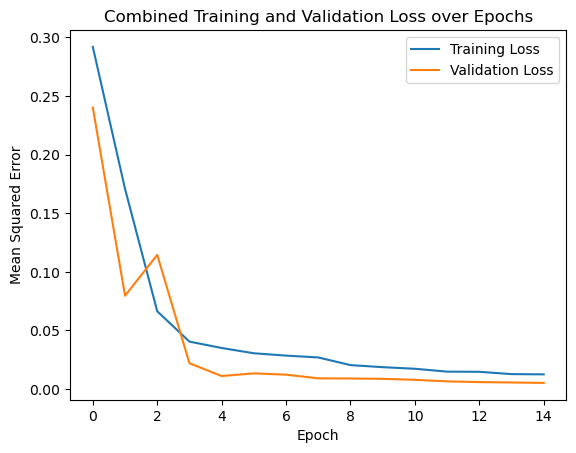

In [45]:
plot_combined_loss(history2)

In [46]:
num_parameters2 = model2.count_params()
print("Parameters number in model0: ", num_parameters2)

Parameters number in model0:  7361


In [47]:
score1 = model2.evaluate(X_test_scaled, y_test)                                                                            

print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name2, l=score1[0], a=score1[1]))

15/15 [==============================] - 0s 941us/step - loss: 0.0174 - mean_absolute_error: 0.1013
3 Layers + Head: More features: Test Mean Squared Error: 0.017448 / Mean Absolute Error: 0.101332


### Evaluation- Plot actual and prediction

15/15 [==============================] - 0s 402us/step


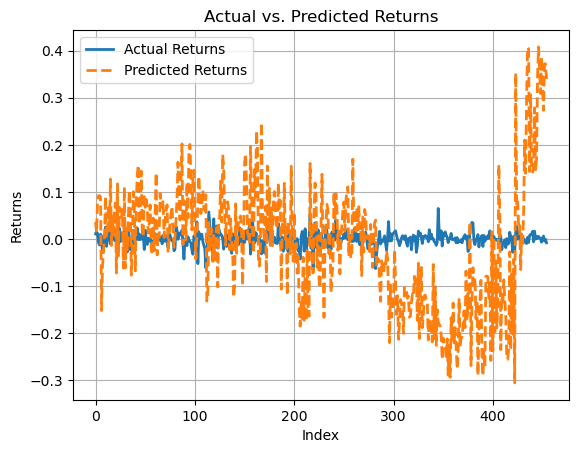

In [48]:
plot_actual_vs_predicted(model2, X_test_scaled, y_test)

## Model with RNN+DNN

In [49]:
from tensorflow.keras.layers import  LSTM
from tensorflow.keras.callbacks import EarlyStopping

X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_reshaped = X_valid_scaled.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

def build_rnn_model(n_lstm_units, n_dense_units, dropout_rate):
    model = Sequential([
        LSTM(n_lstm_units, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])), # In the case of LSTM layers, the input shape should be (time_steps, features).
        Dropout(dropout_rate),
        Dense(n_dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

def compile_and_train_model(model, X_train, y_train, X_valid, y_valid, max_epochs, batch_size, early_stopping_patience):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics)
    
    # Use EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(X_train, y_train, 
                        epochs=max_epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        shuffle=False)
    
    return history

model_3 = build_rnn_model(32,64,0.2)
history3 = compile_and_train_model(model_3, X_train_reshaped, y_train, X_valid_reshaped, y_valid, 15, 64,10)
model_name3 = 'RNN Model'

Epoch 1/15
21/21 [==============================] - 1s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.0679 - val_loss: 0.0101 - val_mean_absolute_error: 0.0797
Epoch 2/15
21/21 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0026 - val_mean_absolute_error: 0.0365
Epoch 3/15
21/21 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0360 - val_loss: 0.0061 - val_mean_absolute_error: 0.0692
Epoch 4/15
21/21 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 9.7259e-04 - val_mean_absolute_error: 0.0237
Epoch 5/15
21/21 [==============================] - 0s 2ms/step - loss: 9.2838e-04 - mean_absolute_error: 0.0219 - val_loss: 8.7868e-04 - val_mean_absolute_error: 0.0228
Epoch 6/15
21/21 [==============================] - 0s 2ms/step - loss: 7.7610e-04 - mean_absolute_error: 0.0201 - val_loss: 6.6455e-04 - val_mean_absolute_error: 0.0194
Epoch 7/

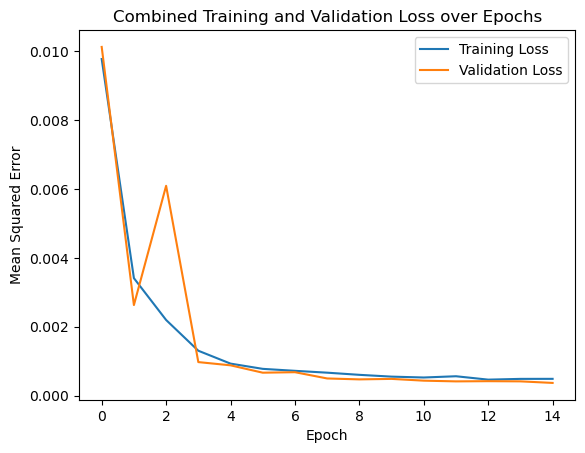

In [50]:
plot_combined_loss(history3)

In [51]:
num_parameters2 = model_3.count_params()
print("Parameters number in model0: ", num_parameters2)

Parameters number in model0:  20865


In [52]:
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

score1 = model_3.evaluate(X_test_reshaped, y_test)                                                                            
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name3, l=score1[0], a=score1[1]))

15/15 [==============================] - 0s 497us/step - loss: 0.0013 - mean_absolute_error: 0.0287
RNN Model: Test Mean Squared Error: 0.001348 / Mean Absolute Error: 0.028675


### Evaluation- plot actual vs prediction

15/15 [==============================] - 0s 566us/step


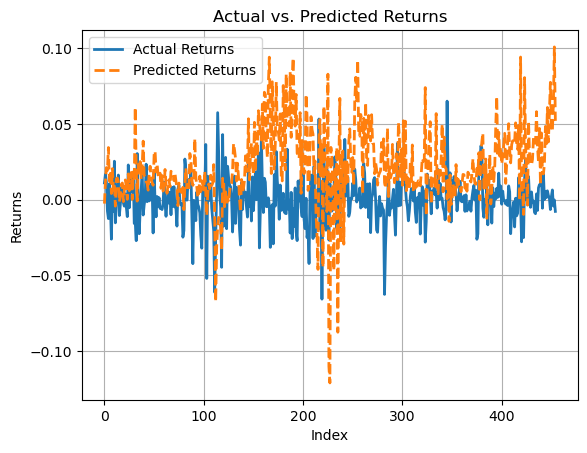

In [53]:
plot_actual_vs_predicted(model_3, X_test_reshaped, y_test)

### Hyperparameter Tuning-First try 25 epoch

In [54]:
model_4 = build_rnn_model(32,64,0.2)
history4 = compile_and_train_model(model_4, X_train_reshaped, y_train, X_valid_reshaped, y_valid, 25, 64,10)

Epoch 1/25
21/21 [==============================] - 1s 7ms/step - loss: 0.0219 - mean_absolute_error: 0.0952 - val_loss: 0.0501 - val_mean_absolute_error: 0.2045
Epoch 2/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_absolute_error: 0.0535 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379
Epoch 3/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0349 - val_loss: 0.0020 - val_mean_absolute_error: 0.0361
Epoch 4/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0295 - val_loss: 9.8254e-04 - val_mean_absolute_error: 0.0246
Epoch 5/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0267 - val_loss: 7.5057e-04 - val_mean_absolute_error: 0.0213
Epoch 6/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0248 - val_loss: 4.9846e-04 - val_mean_absolute_error: 0.0174
Epoch 7/25
21/21

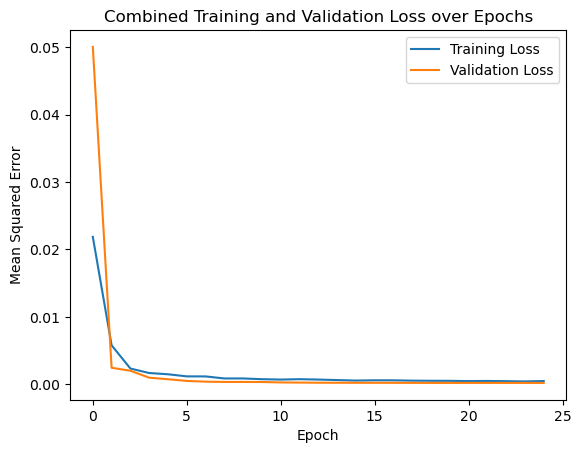

In [55]:
plot_combined_loss(history4)

In [56]:
num_parameters2 = model_4.count_params()
print("Parameters number in model0: ", num_parameters2)

score1 = model_4.evaluate(X_test_reshaped, y_test)                                                                            
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name3, l=score1[0], a=score1[1]))

Parameters number in model0:  20865
15/15 [==============================] - 0s 521us/step - loss: 0.0021 - mean_absolute_error: 0.0308
RNN Model: Test Mean Squared Error: 0.002143 / Mean Absolute Error: 0.030778


15/15 [==============================] - 0s 507us/step


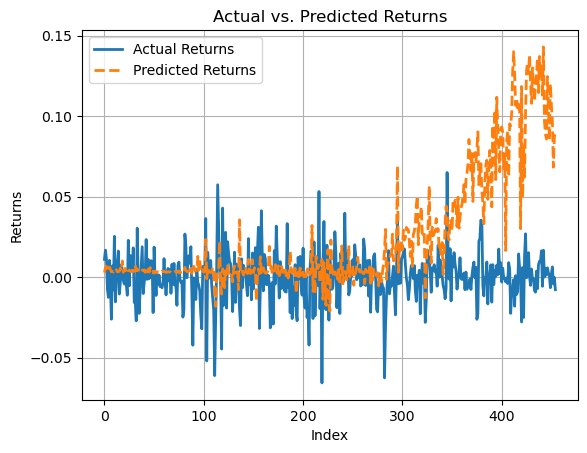

In [57]:
plot_actual_vs_predicted(model_4, X_test_reshaped, y_test)

### Second try 50 epoch

In [58]:
model_5 = build_rnn_model(32,64,0.2)
history5 = compile_and_train_model(model_5, X_train_reshaped, y_train, X_valid_reshaped, y_valid, 50, 64,10)

Epoch 1/50
21/21 [==============================] - 1s 7ms/step - loss: 0.0082 - mean_absolute_error: 0.0647 - val_loss: 0.0031 - val_mean_absolute_error: 0.0423
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0351 - val_loss: 0.0018 - val_mean_absolute_error: 0.0323
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0262 - val_loss: 0.0033 - val_mean_absolute_error: 0.0461
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0239 - val_loss: 0.0029 - val_mean_absolute_error: 0.0454
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 8.7251e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0014 - val_mean_absolute_error: 0.0297
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 8.3849e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0014 - val_mean_absolute_error: 0.0310
Epoch 7/50
21/21 [==

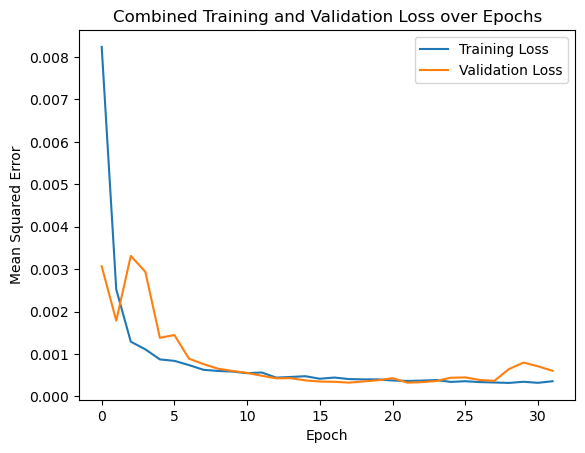

In [59]:
plot_combined_loss(history5)

In [60]:
num_parameters2 = model_5.count_params()
print("Parameters number in model0: ", num_parameters2)

score1 = model_5.evaluate(X_test_reshaped, y_test)                                                                            
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name3, l=score1[0], a=score1[1]))

Parameters number in model0:  20865
15/15 [==============================] - 0s 488us/step - loss: 0.0036 - mean_absolute_error: 0.0379
RNN Model: Test Mean Squared Error: 0.003566 / Mean Absolute Error: 0.037875


15/15 [==============================] - 0s 465us/step


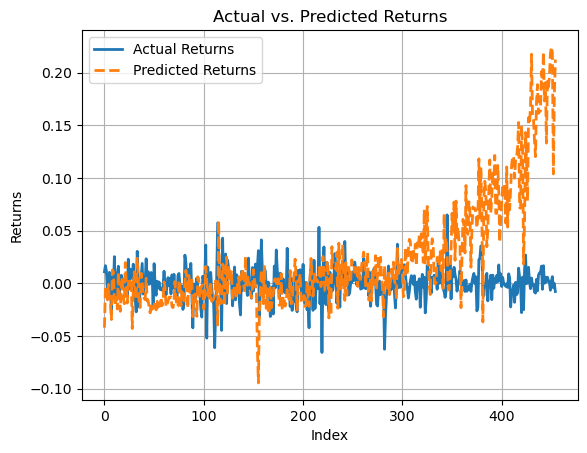

In [61]:
plot_actual_vs_predicted(model_5, X_test_reshaped, y_test)

## Model with RNN(2 LSTM)+ DNN

In [62]:
def build_rnn_model(n_dense_units, dropout_rate):
    model = Sequential([
        LSTM(16, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dropout(dropout_rate),
        LSTM(32, activation='relu', return_sequences=True),
        Dropout(dropout_rate),
        Dense(n_dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

def compile_and_train_model(model, X_train, y_train, X_valid, y_valid, max_epochs, batch_size, early_stopping_patience):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics)
    
    # Use EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(X_train, y_train, 
                        epochs=max_epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        shuffle=False)
    
    return history

model_6 = build_rnn_model(64, 0.2)
history6 = compile_and_train_model(model_6, X_train_reshaped, y_train, X_valid_reshaped, y_valid, 50, 64, 10)
model_name6 = 'RNN Model - More Layer'


Epoch 1/50
21/21 [==============================] - 1s 11ms/step - loss: 6.4747e-04 - mean_absolute_error: 0.0176 - val_loss: 2.6281e-04 - val_mean_absolute_error: 0.0122
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 4.7715e-04 - mean_absolute_error: 0.0156 - val_loss: 1.9542e-04 - val_mean_absolute_error: 0.0100
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 4.6397e-04 - mean_absolute_error: 0.0152 - val_loss: 1.9800e-04 - val_mean_absolute_error: 0.0101
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 4.0976e-04 - mean_absolute_error: 0.0144 - val_loss: 1.9535e-04 - val_mean_absolute_error: 0.0099
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 4.2298e-04 - mean_absolute_error: 0.0145 - val_loss: 1.9586e-04 - val_mean_absolute_error: 0.0099
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 4.1034e-04 - mean_absolute_error: 0.0142 - val_loss: 1.9357e-04 - val_mean_ab

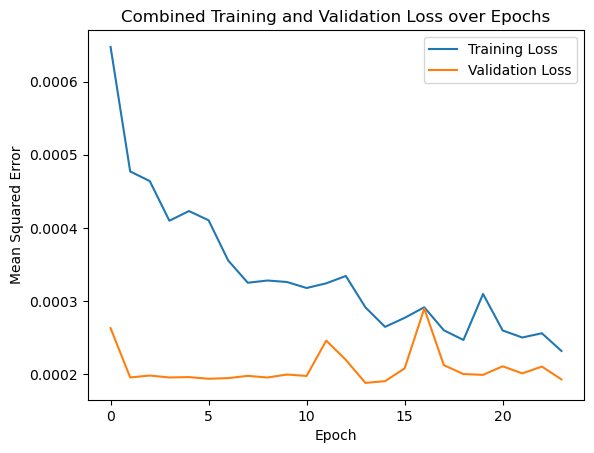

In [63]:
plot_combined_loss(history6)

In [64]:
num_parameters2 = model_6.count_params()
print("Parameters number in model0: ", num_parameters2)

score1 = model_6.evaluate(X_test_reshaped, y_test)                                                                            
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name6, l=score1[0], a=score1[1]))

Parameters number in model0:  17793
15/15 [==============================] - 0s 549us/step - loss: 2.1262e-04 - mean_absolute_error: 0.0107
RNN Model - More Layer: Test Mean Squared Error: 0.000213 / Mean Absolute Error: 0.010676


15/15 [==============================] - 0s 614us/step


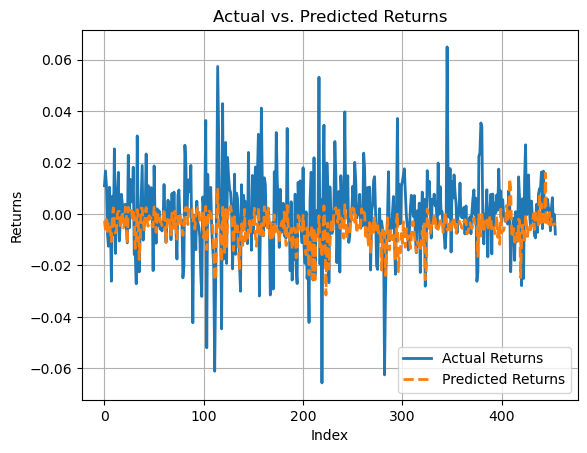

In [65]:
plot_actual_vs_predicted(model_6, X_test_reshaped, y_test)

### Hyperparameter tuning 

In [66]:
model_7 = build_rnn_model(128, 0.2)
history7 = compile_and_train_model(model_7, X_train_reshaped, y_train, X_valid_reshaped, y_valid, 50, 64, 10)

Epoch 1/50
21/21 [==============================] - 1s 11ms/step - loss: 5.6856e-04 - mean_absolute_error: 0.0166 - val_loss: 3.0777e-04 - val_mean_absolute_error: 0.0133
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 4.8829e-04 - mean_absolute_error: 0.0154 - val_loss: 1.9677e-04 - val_mean_absolute_error: 0.0101
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 4.5451e-04 - mean_absolute_error: 0.0149 - val_loss: 1.9610e-04 - val_mean_absolute_error: 0.0099
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 3.9281e-04 - mean_absolute_error: 0.0140 - val_loss: 2.1343e-04 - val_mean_absolute_error: 0.0105
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 3.7673e-04 - mean_absolute_error: 0.0136 - val_loss: 1.9230e-04 - val_mean_absolute_error: 0.0097
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 3.6778e-04 - mean_absolute_error: 0.0135 - val_loss: 1.9102e-04 - val_mean_ab

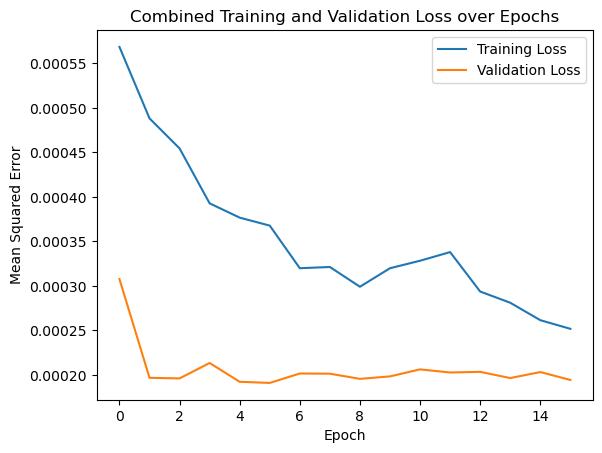

In [67]:
plot_combined_loss(history7)

In [69]:
num_parameters2 = model_7.count_params()
print("Parameters number in model0: ", num_parameters2)

score1 = model_7.evaluate(X_test_reshaped, y_test)                                                                            
print("{n:s}: Test Mean Squared Error: {l:1.6f} / Mean Absolute Error: {a:1.6f}".format(n=model_name3, l=score1[0], a=score1[1]))

Parameters number in model0:  21953
15/15 [==============================] - 0s 532us/step - loss: 3.5283e-04 - mean_absolute_error: 0.0147
RNN Model: Test Mean Squared Error: 0.000353 / Mean Absolute Error: 0.014688


15/15 [==============================] - 0s 605us/step


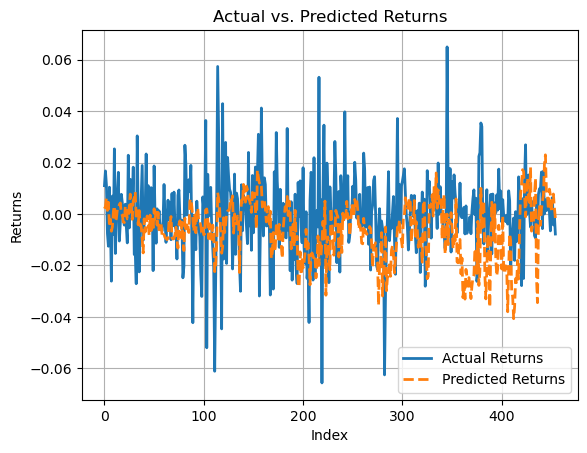

In [70]:
plot_actual_vs_predicted(model_7, X_test_reshaped, y_test)

## Save Model

Model 6 with 2 LSTM layers has the smallest MSE and MAE so I chose it to be my final model.

In [76]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    tickers = ['ADBE', 'MSFT', 'GOOG', 'CRM', 'AAPL', 'NVDA', 'INTC', 'ACN', 'V', 'MA', 'XLK', 'XLV']
    index_ticker = "SPY"
    priceAttr = ["Adj Close", "Volume",'High','Low','Open']
    df = helper.gettestData(tickers, index_ticker, priceAttr,test_dir)
    test_set = transform(df, tickers)
    X_test =  test_set.drop(['AAPL_Return'],axis=1)
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    predictions = model.predict(X_test_reshaped[-200:])
    ids = X_test.index[-200:]
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_6 # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [78]:
print("Done")

Done
